# Network-Based Inter-harmonic Spectral Analysis using Pytorch

> V. Choqueuse

The objective of this notebook is to illustrate the benefit of using a deep learning library for parametric spectral estimation.

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,fftfreq
from scipy.signal import find_peaks
import torch

## Inter-Harmonic Model

Let us assume a signal composed of $L$ (real-valued) cosine components :

$$x[n]=\sum_{n=0}^{L-1}a_n\cos(w_l n+\varphi_n)$$

where the vector containing the $L$ angular frequencies $\mathbf{w} =[w_0,\cdots, w_{L-1}]^T$ is given by

$$\mathbf{w} = \mathbf{F}\boldsymbol  \omega $$

and where $\mathbf{w}$ is vector of $L$ parameters. In this notebook, we consider the inter-harmonic case where $\mathbf{w}$ is given by

$$\mathbf{F}=\begin{bmatrix}1 & 0 \\2& 0\\3&0\\\vdots\\L_1&0\\
1 & -L_2\\
1 & \vdots \\
1& -1\\
1 & 1\\
1 & \vdots \\
1& L_2\\
\end{bmatrix}$$

In [95]:
def signal_model(omega_list,a_list,phi_list,N_vect,sigma2 = 0):
    L = len(a_list)
    x = np.zeros(len(N_vect))
    for k in range(L):
        x += a_list[k]*np.cos(omega_list[k]*N_vect+phi_list[k])

    b = np.sqrt(sigma2)*np.random.randn(len(N_vect))
    x += b
    return x

def get_F(L_vect):
    L1,L2 = L_vect
    F = np.zeros((L1+2*L2,2))
    
    for k in range(L1):
        F[k,0] = k+1
    
    for k in range(1,L2+1):
        F[L1+k-1,0] = 1
        F[L1+k-1,1] = -k 
    
    for k in range(1,L2+1):
        F[L1+L2+k-1,0] = 1
        F[L1+L2+k-1,1] = k 
        
    return F

### Example

For illustration purposes, let us consider the following noisy signal composed of $L=5$ real-valued sine waves.

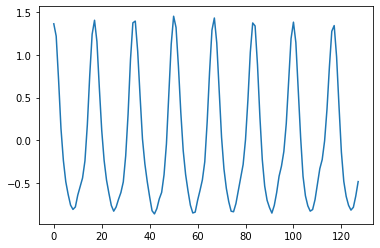

In [96]:
# signal parameter
Fs = 1000
N = 2**7
L = 5
N_vect = np.arange(N,dtype=np.float64)

w_ref = np.array([2*np.pi*60.0/Fs,2*np.pi*7.2/Fs])
L1,L2=3,1
coef = 0.3 # 0 -> no interharmonic
a_list = [1,0.3,0.11,coef*0.243,coef*0.321]
phi_list = [0,-0.2,0,0.4,-3.14]
sigma2 = 0.0001

# generate signal
F = get_F([L1,L2])
w_list_ref = np.matmul(F,w_ref)
x = signal_model(w_list_ref,a_list,phi_list,N_vect,sigma2 = sigma2)
plt.plot(x,label="signal");

## Parameter Estimation

In parametric analysis, the goal is to estimate the signal parameters, i.e. $\boldsymbol \theta=\{\mathbf{a},\boldsymbol  \omega,\boldsymbol\varphi\}$, from $\mathbf{x}=[x[0],\cdots,x[N-1]]$. A classical technique for parameter estimation is based on the Least-Squares (LS) technique. Using the LS technique, the goal is to minimize the following metric

$$\mathcal{J}(\mathbf{w},\mathbf{c})=\|\mathbf{x}-\mathbf{A}(\boldsymbol  \omega)\mathbf{c}\|^2$$

where $\mathbf{c}$ is a complex vector depending on $\mathbf{a}$ and $\boldsymbol\varphi$.
This optimization problem can be divided into two steps [(more)](https://epubs.siam.org/doi/abs/10.1137/0710036):

* **Step 1**: Estimation of the angular frequencies $\boldsymbol \omega$ using the Variational Projection approach

$$\widehat{\boldsymbol \omega} =\arg \min_{\boldsymbol \omega} \|\mathbf{P}^{\perp}(\boldsymbol \omega)\mathbf{x}\|^2$$

where $\mathbf{P}^{\perp}(\boldsymbol \omega)=\mathbf{I}_N-\mathbf{A}(\boldsymbol \omega)\mathbf{A}^{\dagger}(\boldsymbol \omega)$ is the orthogonal projector into the noise subspace.

* **Step 2**: LS Estimation of the phasor ($\mathbf{a}$, $\boldsymbol\varphi$).

The first step is the most computational demanding task and is usually performed using the Levenberg-Marquardt algorithm. A classical low-complexity approach for spectral estimation is based on the periodogram. Even if this approach has low computational complexity, it usually suffers from a poor spectral resolution. Other approaches include subspace techniques (MUSIC, ESPRIT).


In this notebook, I show how to estimate the signal parameters using a two-step approach:

* Initialization of the parameters $\boldsymbol \theta=\{\mathbf{a},\boldsymbol \omega,\boldsymbol\varphi\}$ using the low-complexity periodogram technique.
* Refined estimation of the parameters using a Pytorch custom network.

### Periodogram based spectral Estimation

To estimate the signal parameter, a simple technique is based on the periodogram. First, the fndamental angular frequency is estimated by locating the highest peak of the periodogram. Then, the amplitude and the phase of the sine wave signals are extracted from these $L$ peaks.

value of w0=[[3.92699082e-01]
 [1.00000000e-04]]


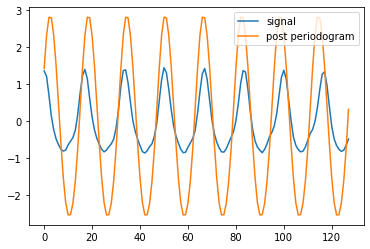

In [97]:
N = len(x)
fft_x = 2*fft(x)/N
freq_list = fftfreq(N)
fft_x_half = fft_x[:int(N/2)]
peaks_locations,_ = find_peaks(np.abs(fft_x_half)**2)

# identification of the first peak (which is assumed to corresponds to the fundamental component)
fft_x_peaks_abs = np.abs(fft_x[peaks_locations])
index_sorted = np.argsort(fft_x_peaks_abs)[::-1]
peaks_locations = peaks_locations[index_sorted[0]] # keep the highest peak

# compute initial parameters
w0 = 2*np.pi*freq_list[peaks_locations]
w_init = np.array([w0,0.0001]).reshape((-1,1)) # the second parameters is initialized to a small value
w_vect = np.matmul(F,w_init)

a_init = []
phi_init = []
for w in w_vect:
    c = (2/N)*np.sum(x*np.exp(-1j*w*np.arange(N)))
    a_init.append(np.abs(c))
    phi_init.append(np.angle(c))

x_est = signal_model(w_vect,a_init,phi_init,N_vect)
plt.plot(x,label="signal")
plt.plot(x_est,label="post periodogram")
plt.legend();

print("value of w0={}".format(w_init))

### Refined Estimation using Pytorch


#### Network structure 

Let us consider a network with input $\mathbf{N}=[1,2,3,\cdots,N]$. In the following we construct a network composed of 4 layers:

* The first layer performs a multiplication between $\omega_l$ and $\mathbf{N}$ for $l\in \{1,\cdots,L\}$ (input: $N$, output: $L\times N$)
* The second layer add the phase term $\varphi_l$ for $l\in \{1,\cdots,L\}$ (input: $L\times N$, output: $L\times N$)
* The third layer is a non-linear layer that applies the cosine function (input: $L\times N$, output: $L\times N$)
* The fourth layer performs a multiplication between $a_l$ and the output of the previous layer (input: $L\times N$, output: $L\times N$)

The output of the network corresponds to the $L$ harmonic components (size $L\times N$).

In [98]:
class Spectral_Net(torch.nn.Module):

    def __init__(self,w_init,L_list,a_init,phi_init):
        super(Spectral_Net, self).__init__()
        self.w = torch.nn.Parameter(torch.tensor(w_init))
        self.phi = torch.nn.Parameter(torch.Tensor(phi_init))
        self.a = torch.nn.Parameter(torch.tensor(a_init))
        self.F = torch.from_numpy(get_F(L_list))
        
    def forward(self, x):
        omega = torch.matmul(self.F,self.w)
        omega_n = omega*x
        phi = self.phi[:, None] 
        cos_n = torch.cos(omega_n + phi)
        amp = self.a[:, None] 
        y = amp*cos_n
        return y

That's it ! Now, let us improve our periodogram based estimator using a training stage. During training, we compute the MSE error between the sum of network outputs and the reference signal. To avoid mode mixing between the harmonic and interharmonic components, we also add a $\mathcal{L}_2$ regularizer to the cost function 

$$\mathcal{L}(\boldsymbol \theta)= \|\mathbf{x}-\mathbf{1}^T\mathbf{Y}(\boldsymbol \theta)\|^2+\lambda \|\mathbf{e}^T\mathbf{a}\|^2$$

where $\mathbf{1}=[1,\cdots,1]^T$ is a vector composed of $L$ ones and $\mathbf{e}$ is vector containing one for the index of interharmonics and zero elsewhere.

In [99]:
L_list = [L1,L2]
w =  torch.from_numpy(w_init)
model = Spectral_Net(w_init,L_list,a_init,phi_init)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_vect_torch = torch.from_numpy(N_vect)
y_torch = torch.from_numpy(x)

lamb = 0.2

for t in range(20000):
    # Forward pass: Compute predicted y by passing x to the model
    Y_pred = model(n_vect_torch)
    y_pred = torch.sum(Y_pred,dim=0)  #sum the L components here
    for name, param in model.named_parameters():
        if name in ['a']:
            y_pred += lamb*torch.norm(param[3:])
        
    # Compute and print loss
    loss = criterion(y_pred, y_torch)
    if t % 1000 == 0:
        print("it {}: loss={}".format(t, loss.item()/N))

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("value of w0 - {}".format(list(model.parameters())[0]))

it 0: loss=1.8644256109585662
it 1000: loss=0.033372388725916566
it 2000: loss=0.011002347616241645
it 3000: loss=0.008526472238432878
it 4000: loss=0.006168843966453896
it 5000: loss=0.004481996849301261
it 6000: loss=0.004040780313457604
it 7000: loss=0.003973146516076039
it 8000: loss=0.0038162339207036644
it 9000: loss=0.0034457873695509502
it 10000: loss=0.0020925358903901713
it 11000: loss=0.0010916844285998885
it 12000: loss=0.0007007827430462921
it 13000: loss=0.0006506252940112412
it 14000: loss=0.0006487917116818164
it 15000: loss=0.0006487974605040504
it 16000: loss=0.0006489715086894345
it 17000: loss=0.000661164270947523
it 18000: loss=0.0006487827844264698
it 19000: loss=0.0006487827845154961
value of w0 - Parameter containing:
tensor([[0.3773],
        [0.0467]], dtype=torch.float64, requires_grad=True)


## Reconstructed signal

The following code plots the noisy signal, the reconstructed signal based on the periodogram technique and the reconstructed signal after Pytorch refined estimation. We can observe that the proposed network is able to improve the fitting. As compared to other optimization technique, the proposed methodology is much more flexible, there is no need to compute gradient explicitely. Furthermore, the network can be easily extended to deal with more complex signal model by using custom layer.

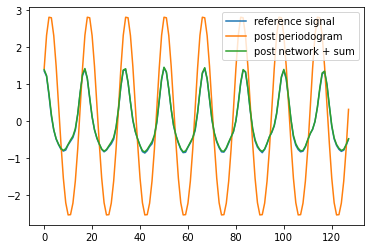

In [100]:
x_est2 = y_pred.detach().numpy()

plt.plot(x,label="reference signal")
plt.plot(x_est,label="post periodogram")
plt.plot(x_est2,label="post network + sum")
plt.legend();

## Demixed Components

The network output is a $L\times N$ tensor where each row corresponds to a single harmonic component. In this configuration, the network is able to separate the harmonic component. The following script plots the $L$ components.

(-2.0, 2.0)

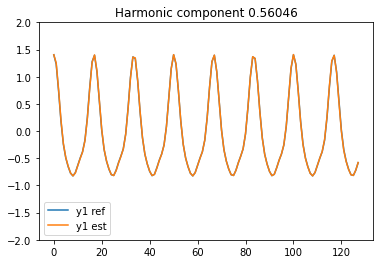

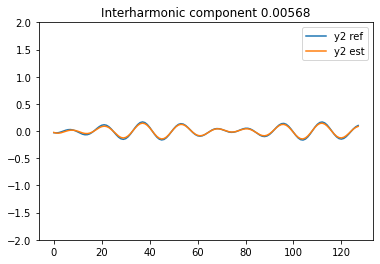

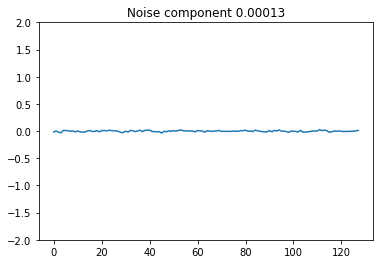

In [101]:
Y_pred2 = Y_pred.detach().numpy()

y1 = np.sum(Y_pred2[:L1,:],axis=0)
sigma2_1 = np.var(y1)
y2 = np.sum(Y_pred2[L1:,:],axis=0)
sigma2_2 = np.var(y2)
noise = x-y1-y2
sigma2_3 = np.var(noise)

e = np.array([1,1,1,0,0])
y1_ref = signal_model(w_list_ref,a_list*e,phi_list*e,N_vect)
e = np.array([0,0,0,1,1])
y2_ref = signal_model(w_list_ref,a_list*e,phi_list*e,N_vect)

plt.figure()
plt.title("Harmonic component {:.5f}".format(sigma2_1))
plt.plot(y1_ref,label="y1 ref")
plt.plot(y1,label="y1 est")
plt.ylim([-2,2])
plt.legend()
             
plt.figure()
plt.title("Interharmonic component {:.5f}".format(sigma2_2))
plt.plot(y2_ref,label="y2 ref")
plt.plot(y2,label="y2 est")
plt.ylim([-2,2])
plt.legend()

plt.figure()
plt.title("Noise component {:.5f}".format(sigma2_3))
plt.plot(noise)
plt.ylim([-2,2])